# Validate the 3D cyl mesh on a DC Horizontal Electric dipole

- use a simple mesh and compare the DC solution on the 3D cyl meshes to the analytic for an electric dipole at zero frequency

In [1]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.constants import mu_0, inch, foot

# SimPEG 
import discretize
from discretize import utils
from SimPEG.EM.Static import DC
from SimPEG import Utils, Maps
import geoana
from pymatsolver import Pardiso

# casing utilities
import casingSimulations


%matplotlib inline

In [2]:
sigma_back = 1e-1

In [3]:
csx, ncx, npadx = 1, 50, 30
ncy = 10
csz, ncz, npadz = 1, 50, 30

hx = Utils.meshTensor([(csx, ncx), (csx, npadx, 1.3)])

ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

hz = Utils.meshTensor([(csz, npadz, -1.3), (csz, ncz), (csz, npadz, 1.3)])

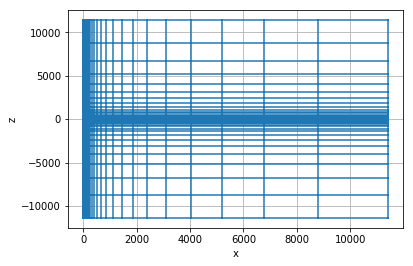

In [4]:
mesh2D = discretize.CylMesh([hx, 1., hz], x0='00C')
mesh2D.plotGrid()

In [5]:
mesh3D = discretize.CylMesh([hx, hy, hz], x0='00C')

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


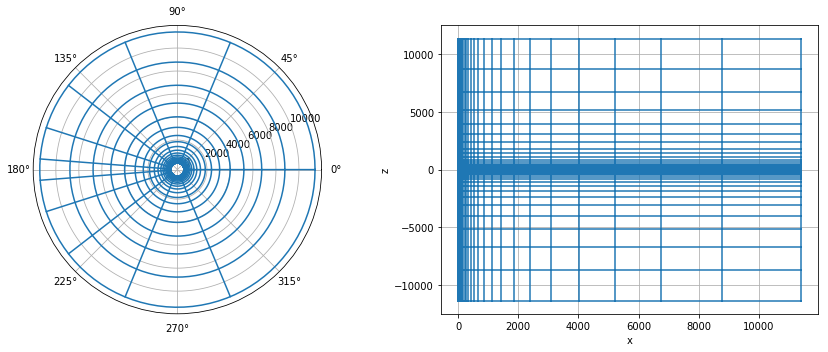

In [6]:
mesh3D.plotGrid()

In [7]:
src_a = np.r_[30+csx/2., np.pi, csz/2.]
src_b = np.r_[40+csx/2., np.pi, csz/2.]

(-10.0, 10.0)

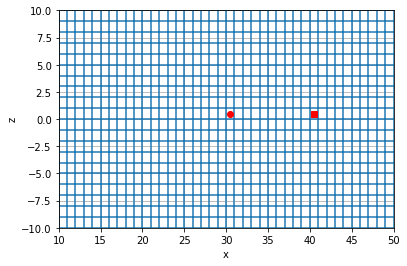

In [8]:
fig, ax = plt.subplots(1, 1)
mesh3D.plotGrid(ax=ax, slice='theta')

ax.plot(src_a[0], src_a[2], 'ro')
ax.plot(src_b[0], src_b[2], 'rs')

ax.set_xlim([10., 50.])
ax.set_ylim([-10., 10.])

(0.0, 50)

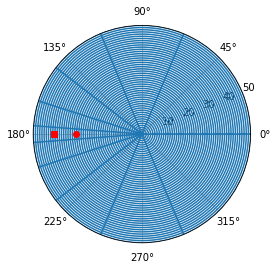

In [9]:
ax = plt.subplot(111, projection='polar')
mesh3D.plotGrid(ax=ax, slice='z')
ax.plot(src_a[1], src_a[0], 'ro')
ax.plot(src_b[1], src_b[0], 'rs')

ax.set_rlim([0., 50])

In [10]:
src = DC.Src.Dipole([], src_a, src_b)

In [11]:
prob3D = DC.Problem3D_CC(mesh3D, sigmaMap=Maps.SurjectFull(mesh3D), bc_type='Dirichlet', Solver=Pardiso)
survey3D = DC.Survey([src])

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [12]:
prob3D.pair(survey3D)

In [13]:
%%time
fields3D = prob3D.fields(np.r_[sigma_back])

CPU times: user 3.93 s, sys: 310 ms, total: 4.24 s
Wall time: 3.04 s


In [14]:
length = src_b[0] - src_a[0]
loc = np.r_[-(src_b[0] + src_a[0])/2., 0., src_b[2]]
current = 1

e_dipole = geoana.em.fdem.ElectricDipoleWholeSpace(
    current=current, location=loc, length=length, orientation='x',
    frequency=0, sigma=sigma_back
)

eana_Fx = e_dipole.electric_field(mesh3D.cartesianGrid('Fx'))
eana_Fy = e_dipole.electric_field(mesh3D.cartesianGrid('Fy'))
eana_Fz = e_dipole.electric_field(mesh3D.cartesianGrid('Fz'))

In [15]:
j3D = fields3D[src, 'j']
e3D = fields3D[src, 'e']

In [16]:
phi = fields3D[src, 'phi'].reshape(mesh3D.vnC, order='F')

[(-50.0, 50.0), (-50.0, 50.0)]

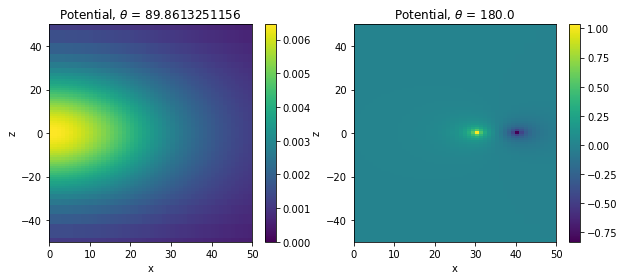

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
tind = [1, 5]

plt.colorbar(mesh2D.plotImage(utils.mkvc(phi[:,tind[0],:]), mirror=False, ax=ax[0])[0], ax=ax[0])
plt.colorbar(mesh2D.plotImage(utils.mkvc(phi[:,tind[1],:]), mirror=False, ax=ax[1])[0], ax=ax[1])


[a.set_title('Potential, $\\theta$ = {}'.format(mesh3D.vectorCCy[t]*180./np.pi)) for a,t in zip(ax,tind)]
[a.set_xlim([0., 50.]) for a in ax]
[a.set_ylim([-50., 50.]) for a in ax]

# Cross section aligned with source $\theta = 180^\circ$

In [18]:
theta_ind = 5
theta = mesh3D.vectorCCy[theta_ind]*180./np.pi
print('theta = {}'.format(theta))
jplt = casingSimulations.face3DthetaSlice(mesh3D, j3D, theta_ind=theta_ind)
eplt = casingSimulations.face3DthetaSlice(mesh3D, e3D, theta_ind=theta_ind)

theta = 180.0


In [19]:
eana_plt_x = -1*utils.mkvc(eana_Fx[:,0].reshape(mesh3D.vnFx, order='F')[:, theta_ind, :], 2)
eana_plt_z = utils.mkvc(eana_Fz[:, 2].reshape(mesh3D.vnFz, order='F')[:, theta_ind, :], 2)
eanaplt = np.vstack([eana_plt_x, eana_plt_z])

janaplt = sigma_back*eanaplt

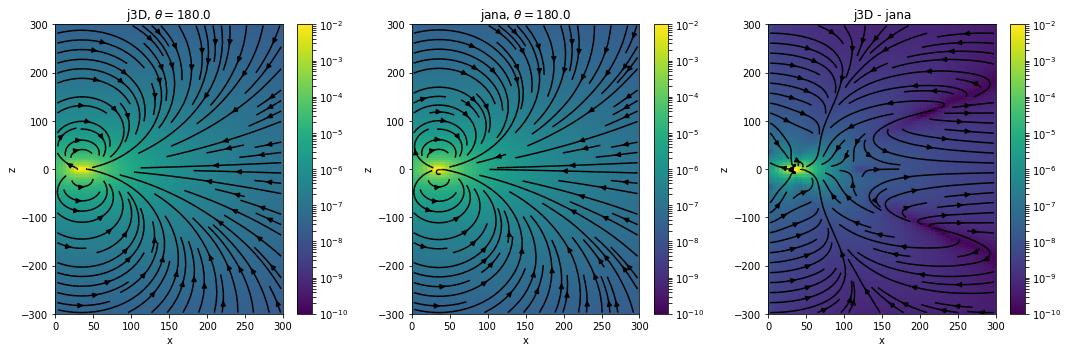

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'mirror':False,
    'range_x':np.r_[0., 300.],
    'range_y':np.r_[-300., 300.],
    'sample_grid':np.r_[5.,5.],
    'clim':np.r_[1e-10, 1e-2]
}

casingSimulations.plotFace2D(
    mesh2D, jplt, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, janaplt, ax=ax[1], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, jplt-janaplt, ax=ax[2], **pltargs
)

ax[0].set_title('j3D, $\\theta = {}$'.format(theta))
ax[1].set_title('jana, $\\theta = {}$'.format(theta))
ax[2].set_title('j3D - jana')

plt.tight_layout()

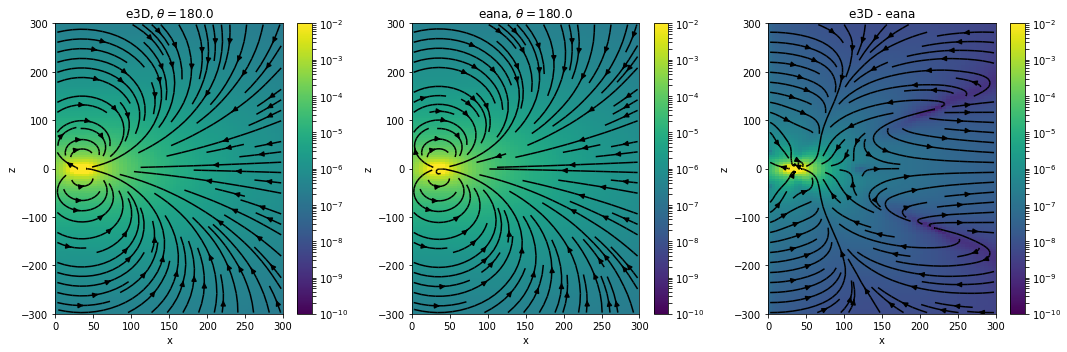

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'mirror':False,
    'range_x':np.r_[0., 300.],
    'range_y':np.r_[-300., 300.],
    'sample_grid':np.r_[5.,5.],
    'clim':np.r_[1e-10, 1e-2]
}

casingSimulations.plotFace2D(
    mesh2D, eplt, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, eanaplt, ax=ax[1], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, eplt-eanaplt, ax=ax[2], **pltargs
)

ax[0].set_title('e3D, $\\theta = {}$'.format(theta))
ax[1].set_title('eana, $\\theta = {}$'.format(theta))
ax[2].set_title('e3D - eana')

plt.tight_layout()

## Look at the $\theta = 90^\circ$ slice

In [22]:
theta_ind = 1
theta = mesh3D.vectorCCy[theta_ind]*180./np.pi
print('theta = {}'.format(theta))
jplt = casingSimulations.face3DthetaSlice(mesh3D, j3D, theta_ind=theta_ind)
eplt = casingSimulations.face3DthetaSlice(mesh3D, e3D, theta_ind=theta_ind)

theta = 89.8613251156


In [23]:
eana_plt_x = utils.mkvc(eana_Fx[:, 1].reshape(mesh3D.vnFx, order='F')[:, theta_ind, :], 2)
eana_plt_z = utils.mkvc(eana_Fz[:, 2].reshape(mesh3D.vnFz, order='F')[:, theta_ind, :], 2)
eanaplt = np.vstack([eana_plt_x, eana_plt_z])

janaplt = sigma_back*eanaplt

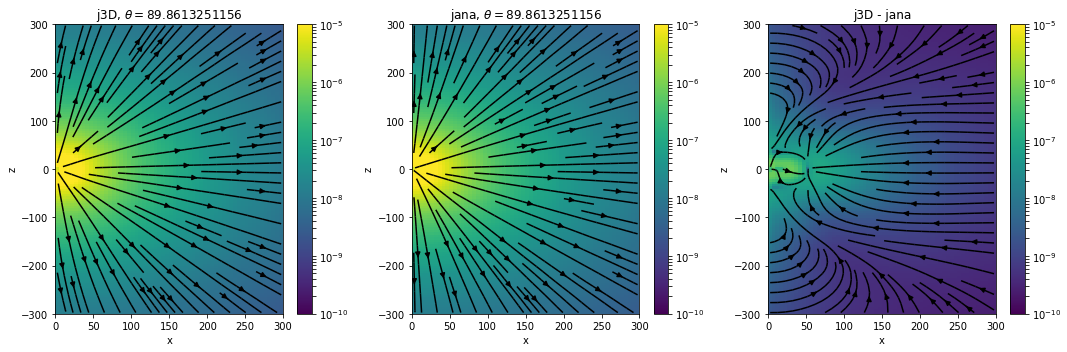

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'mirror':False,
    'range_x':np.r_[0., 300.],
    'range_y':np.r_[-300., 300.],
    'sample_grid':np.r_[5.,5.],
    'clim':np.r_[1e-10, 1e-5]
}

casingSimulations.plotFace2D(
    mesh2D, jplt, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, janaplt, ax=ax[1], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, jplt-janaplt, ax=ax[2], **pltargs
)

ax[0].set_title('j3D, $\\theta = {}$'.format(theta))
ax[1].set_title('jana, $\\theta = {}$'.format(theta))
ax[2].set_title('j3D - jana')

plt.tight_layout()

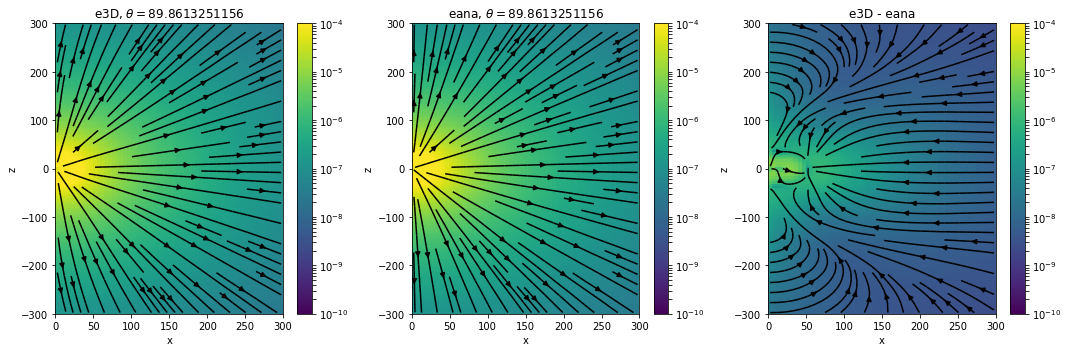

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'mirror':False,
    'range_x':np.r_[0., 300.],
    'range_y':np.r_[-300., 300.],
    'sample_grid':np.r_[5.,5.],
    'clim':np.r_[1e-10, 1e-4]
}

casingSimulations.plotFace2D(
    mesh2D, eplt, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, eanaplt, ax=ax[1], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, eplt-eanaplt, ax=ax[2], **pltargs
)

ax[0].set_title('e3D, $\\theta = {}$'.format(theta))
ax[1].set_title('eana, $\\theta = {}$'.format(theta))
ax[2].set_title('e3D - eana')

plt.tight_layout()

### Include assert statements

Away from the source, we expect good agreement between the electric field and current density. The following lines chech that

In [26]:
def normalized_error(val1, val2):
    return np.linalg.norm(val1 - val2) / np.linalg.norm(0.5*(val1+val2))

In [27]:
assert normalized_error(eplt, eanaplt) < 0.05
assert normalized_error(jplt, janaplt) < 0.05

# Line plots along the $90^\circ$ slice

In [28]:
# line plots
e3D_x = eplt[:mesh2D.vnF[0]].reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F')
e3D_z = eplt[-mesh2D.vnF[2]:].reshape([mesh2D.vnFz[0], mesh2D.vnFz[2]], order='F')

eana_x = eana_plt_x.reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F')
eana_z = eana_plt_z.reshape([mesh2D.vnFz[0], mesh2D.vnFz[2]], order='F')

In [29]:
def plot_lines(x, e3D=None, eana=None, xlim=[0., 100.], name=None, xlabel=None):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    ax = utils.mkvc(ax)
    
    plt_ind = (x > xlim[0]) & (x < xlim[1])
    
    x = x[plt_ind]
    if e3D is not None: e3D = e3D[plt_ind]
    if eana is not None: eana = eana[plt_ind]
    
    # Plot real
    if any(eana.real > 0): 
        if e3D is not None: ax[0].semilogy(x, e3D.real, '-g', label='3D')
        if eana is not None: ax[0].semilogy(x, eana.real, '-r', label='ana')
    if any(eana.real < 0): 
        if e3D is not None: ax[0].semilogy(x, -e3D.real, '--g', label='3D')
        if eana is not None: ax[0].semilogy(x, -eana.real, '--r', label='ana')
        
    ax[0].set_xlim(xlim)
    ax[0].set_title('{}'.format(name))
    ax[0].legend()


    if e3D is not None: ax[1].semilogy(x, np.absolute(e3D.real - eana.real), '-g', label='3D')

    ax[1].set_xlim(xlim)
    ax[1].set_title('{} error'.format(name))
    ax[1].legend()

 
    if e3D is not None: ax[2].plot(
        x, (e3D.real - eana.real)/(eana.real), '-g', label='3D'
    )

    ax[2].set_xlim(xlim)
    ax[2].set_ylim(0.1*np.r_[-1, 1])
    ax[2].set_title('{} error ratio'.format(name))
    ax[2].legend()
        
    [a.set_ylim([np.absolute(eana).min()*0.05, np.absolute(eana).max()*2]) for a in ax[:2]]
    [a.grid(which='both', linestyle='-', color=[0.8, 0.8, 0.8, 0.5], linewidth=0.5) for a in ax]
    
    if xlabel is not None:
        [a.set_xlabel(xlabel) for a in ax]
    plt.tight_layout()
    
    return fig, ax

    

looking at z=-0.500000000002


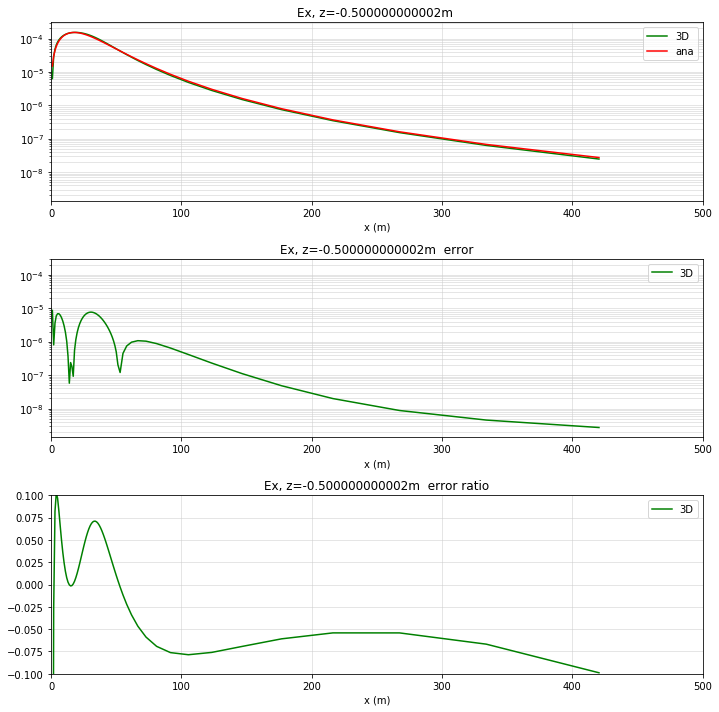

In [30]:
z_ind = mesh2D.vnC[2]/2 - 1
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(
    mesh2D.vectorNx, e3D_x[:, z_ind], eana_x[:, z_ind], xlim=[0., 500.], 
    name='Ex, z={}m '.format(mesh2D.vectorCCz[z_ind]), xlabel='x (m)'
)

looking at x=15.5


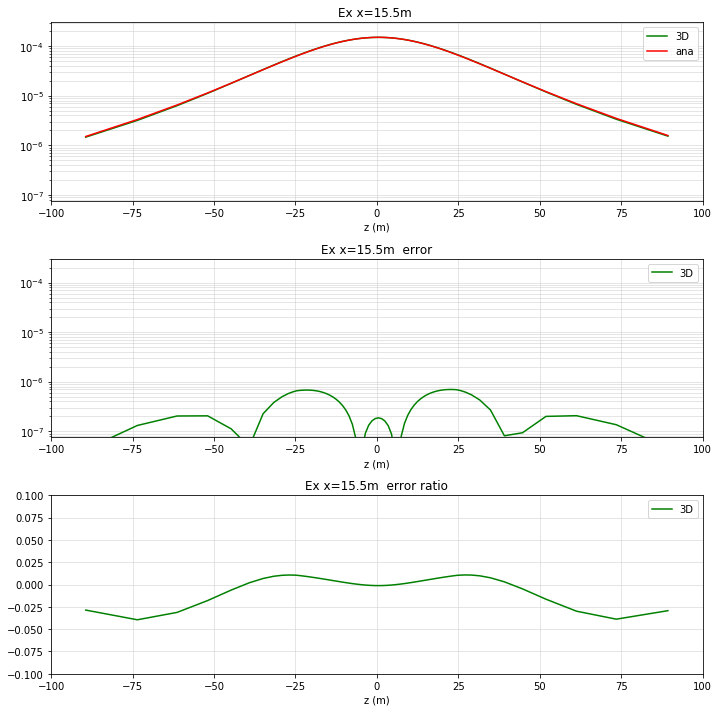

In [31]:
x_ind =  15
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(
    mesh2D.vectorCCz, e3D_x[x_ind, :], eana_x[x_ind, :], xlim=[-100., 100.], 
    name='Ex x={}m '.format(mesh2D.vectorCCx[x_ind]), xlabel = 'z (m)'
)

looking at z=10.5


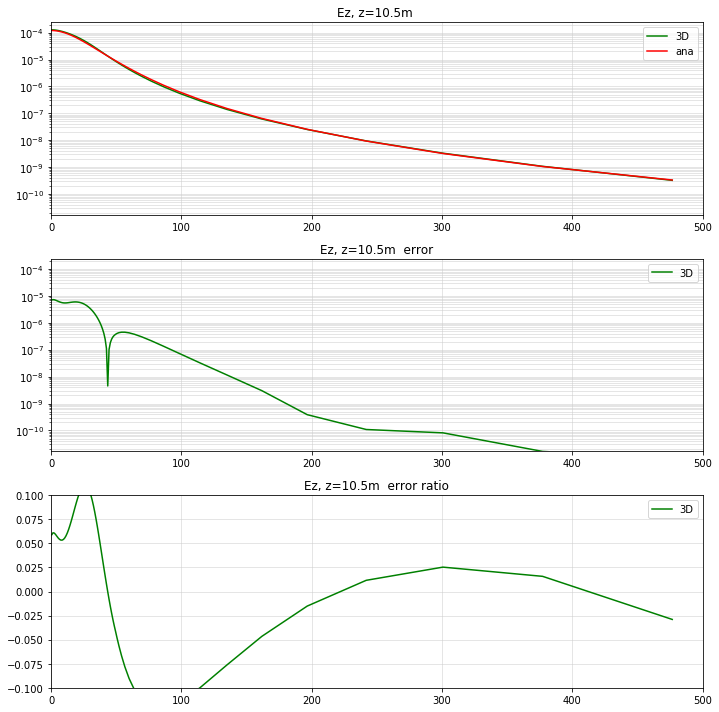

In [32]:
z_ind = mesh2D.vnC[2]/2 + 10
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(
    mesh2D.vectorCCx, e3D_z[:, z_ind], eana_z[:, z_ind], xlim=[0., 500.], 
    name='Ez, z={}m '.format(mesh2D.vectorCCz[z_ind])
)

looking at x=15.5


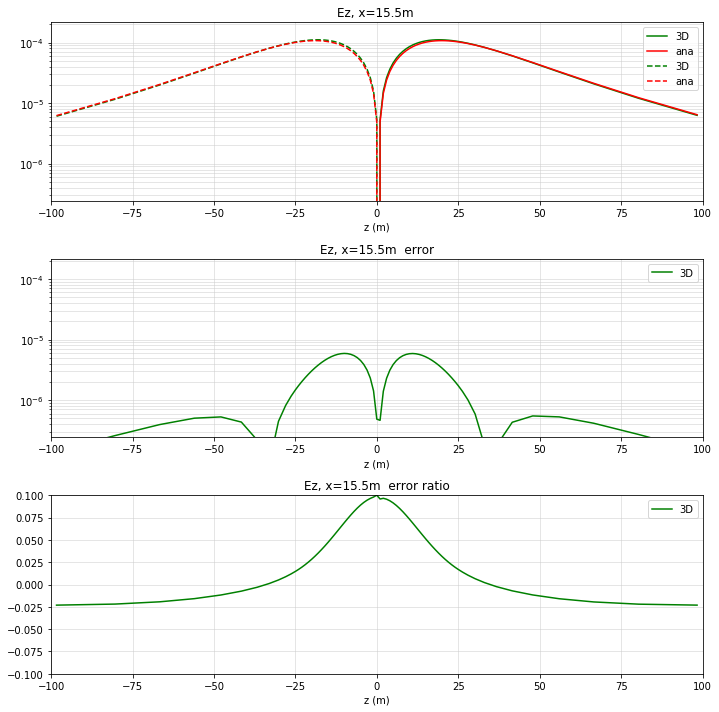

In [33]:
x_ind =  15
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(
    mesh2D.vectorNz, e3D_z[x_ind, :], eana_z[x_ind, :], xlim=[-100., 100.], 
    name='Ez, x={}m '.format(mesh2D.vectorCCx[x_ind]), xlabel='z (m)'
)